In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse

import pandas as pd
import numpy as np
import os
import xarray as xr

import astropy.units as au
import astropy.constants as ac

import sys

sys.path.insert(0, "../python/")

In [2]:
plt.style.use('ncr-paper.mplstyle')

In [3]:
from pyathena.tigress_ncr.ncr_paper_lowz import PaperData,LowZData,add_torb,add_boxplot,athena_data

ModuleNotFoundError: No module named 'pyathena.tigress_ncr'

In [5]:
pdata = LowZData()

LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0.
LoadSimTIGRESSNCR-WARNING: rst files not found in /scratch/gpfs/changgoo/TIGRESS-NCR/R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0.
LoadSimTIGRESSNCR-WARNING: rs

R8-S30 R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps0.0
R8-S30 R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps0.0
R8-b10 R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8-b10 R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8-b10 R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8-b10 R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
R8-b1 R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8-b1 R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8-b1 R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8-b1 R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
LGR8-S05 LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg1.Zd1.xy4096.eps0.0
LGR8-S05 LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0
LGR4-S100 LGR4_4pc_NCR_S100.full.b1.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01
LGR4-S100 LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4-S100 LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4-b10 LGR4_4pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy10

In [6]:
from pyathena.tigress_ncr.cooling_breakdown import *
from pyathena.tigress_ncr.phase import *

In [7]:
import scipy.special as sc

In [8]:
from pyathena.tigress_ncr.get_cooling import *
import pyathena.microphysics.cool as cool

In [9]:
def get_means(data,ph):
    flist=['PE','CR','CII','OI',
           'chi_FUV',
           'cool_rate','heat_rate',
           'pok','nH','T',
           'xe','xHI','xHII',
           'ne','nHI','nHII']
    for f in flist: data[f]
    Nph = ph.sum(dim=['x','y'])
    # density sum
    nsum = (data['nH']*ph).sum(dim=['x','y'])
    vsum = ph.sum(dim=['x','y'])
    # volume weighted means
    v_means = (data.data[flist]*ph).sum(dim=['x','y'])/vsum
    # density weigthed means
    n_means = (data['nH']*data.data[flist]*ph).sum(dim=['x','y'])/nsum

    return v_means,n_means

In [10]:
def construct_timeseries(pdata,m,force_override=False):
    s = pdata.sa.set_model(m)

    outdir = os.path.join(s.savdir,'hst2')
    outfile = os.path.join(outdir,'PEheating.nc')
    outfile2 = os.path.join(outdir,'phase_vmeans.nc')
    outfile3 = os.path.join(outdir,'phase_nmeans.nc')
    if os.path.isfile(outfile2) and (not force_override):
        with xr.open_dataarray(outfile) as da:
            da.load()
        with xr.open_dataset(outfile2) as ds1:
            ds1.load()
        with xr.open_dataset(outfile3) as ds2:
            ds2.load()

        return da,ds1,ds2

    return da,ds1,ds2

In [11]:
from pyathena.tigress_ncr.phase import *

In [12]:
def plot_points(dset,xf,yf,color=None,
                cf='Zgas',cmin=0.03,cmax=1,cmap = plt.cm.viridis):

    qdset = dset.quantile([0.16,0.50,0.84],dim='time').rename(quantile='q')
    qlow = qdset.sel(q=0.16)
    qmid = qdset.sel(q=0.50)
    qhigh = qdset.sel(q=0.84)
    qx = np.array([qlow[xf],qmid[xf],qhigh[xf]])
    qy = np.array([qlow[yf],qmid[yf],qhigh[yf]])
    xerr=np.array([qx[1]-qx[0],qx[2]-qx[1]]).T
    yerr=np.array([qy[1]-qy[0],qy[2]-qy[1]]).T
    if color is None:
        norm = LogNorm(vmin=cmin,vmax=cmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        c = cmap(norm(qmid[cf]))
    else:
        c = color
    # for x_, y_, xerr_, yerr_, c_ in zip(qx[1],qy[1],xerr,yerr,c):
    plt.errorbar(qx[1],qy[1],xerr=xerr.reshape(2,1),yerr=yerr.reshape(2,1),c=c,
                 marker='o',markersize=5,
                 elinewidth=1,ecolor='k',markeredgecolor='k',ls='')

    sca = plt.scatter(dset[xf],dset[yf],color=c,marker='o',s=10,alpha=0.1,linewidths=0)
    plt.yscale('log')
    plt.xscale('log')

def plot_points(x,y,color=None,
                cf='Zgas',cmin=0.03,cmax=1,cmap = plt.cm.viridis):
    xlow,xmid,xhigh = np.nanquantile(x,[0.16,0.50,0.84])
    ylow,ymid,yhigh = np.nanquantile(y,[0.16,0.50,0.84])
    qx = np.array([xlow,xmid,xhigh])
    qy = np.array([ylow,ymid,yhigh])
    # print(qx,qy)
    xerr=np.array([qx[1]-qx[0],qx[2]-qx[1]]).T
    yerr=np.array([qy[1]-qy[0],qy[2]-qy[1]]).T
    if color is None:
        norm = LogNorm(vmin=cmin,vmax=cmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        c = cmap(norm(qmid[cf]))
    else:
        c = color
    # for x_, y_, xerr_, yerr_, c_ in zip(qx[1],qy[1],xerr,yerr,c):
    plt.errorbar(qx[1],qy[1],xerr=xerr.reshape(2,1),yerr=yerr.reshape(2,1),c=c,
                 marker='o',markersize=5,
                 elinewidth=1,ecolor='k',markeredgecolor='k',ls='')
    sca = plt.scatter(x,y,color=c,marker='o',s=10,alpha=0.1,linewidths=0)
    plt.yscale('log')
    plt.xscale('log')

In [13]:
outdir = '/tigress/changgoo/public_html/TIGRESS-NCR/lowZ-figures/'

In [14]:
with xr.open_dataarray('percentiles_all.nc') as qdset:
    W = qdset.sel(q='mean').sel(variable='W')

In [15]:
def plot_point(pdata,m,yf,xf='W',weight='mass',phase=None,factor=1,**kwargs):
    s = pdata.sa.set_model(m)
    da,ds1,ds2 = construct_timeseries(pdata,m,force_override=False)
    # ds1 : volume-weighted mean
    # ds2 : density-weighted mean
    if weight == 'mass':
        ds = ds2
    else:
        ds = ds1
    torb = s.torb_Myr/s.u.Myr
    if s.torb_Myr <50:
        trange = slice(torb*5,torb*15)
    elif s.torb_Myr >300:
        trange = slice(torb*1.5,torb*5)
    else:
        trange = slice(torb*2,torb*5)
    if phase is None:
        dsel = da.sel(time=trange).sel(variable=yf)
    else:
        if yf == 'metal':
            dsel = ds['CII']+ds['OI']
        elif yf == 'PECR':
            dsel = ds['PE']/ds['CR']
        else:
            dsel = ds[yf]
        dsel = dsel.sel(phase=phase).sel(time=trange)

    name = da.name
    if 'Zd0.025' in name:
        marker='s'
    elif 'Om01' in name:
        marker='v'
    elif 'Om02' in name:
        marker='^'
    elif 'b10' in name and not 'S05' in name:
        marker='*'
    else:
        marker='o'

    c = cmap(norm(np.log10(s.Zdust)))
    W = qdset.sel(q='mean').sel(variable=xf)

    plt.plot(W.sel(name=da.name),(dsel).mean()*factor,
             marker=marker,color=c,mew=1,mec='k',**kwargs)
def get_point(pdata,m,yf,xf='W',weight='mass',phase=None):
    s = pdata.sa.set_model(m)
    da,ds1,ds2 = construct_timeseries(pdata,m,force_override=False)
    # ds1 : volume-weighted mean
    # ds2 : density-weighted mean
    if weight == 'mass':
        ds = ds2
    else:
        ds = ds1
    torb = s.torb_Myr/s.u.Myr
    if s.torb_Myr <50:
        trange = slice(torb*5,torb*15)
    elif s.torb_Myr >300:
        trange = slice(torb*1.5,torb*5)
    else:
        trange = slice(torb*2,torb*5)
    if phase is None:
        dsel = da.sel(time=trange).sel(variable=yf)
    else:
        dsel = ds[yf]
        dsel = dsel.sel(phase=phase).sel(time=trange)

    name = da.name

    if 'Zd0.025' in name:
        marker='s'
    elif 'Om01' in name:
        marker='v'
    elif 'Om02' in name:
        marker='^'
    else:
        marker='o'
    if 'b10' in name and not 'S05' in name:
        marker='*'

    c = cmap(norm(np.log10(s.Zdust)))
    W = qdset.sel(q='mean').sel(variable=xf)
    kwargs=dict(marker=marker,color=c,mew=1,mec='k')

    return W.sel(name=da.name),dsel,kwargs

R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps0.0
R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg1.Zd1.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0
LGR4_4pc_NCR_S100.full.b1.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8


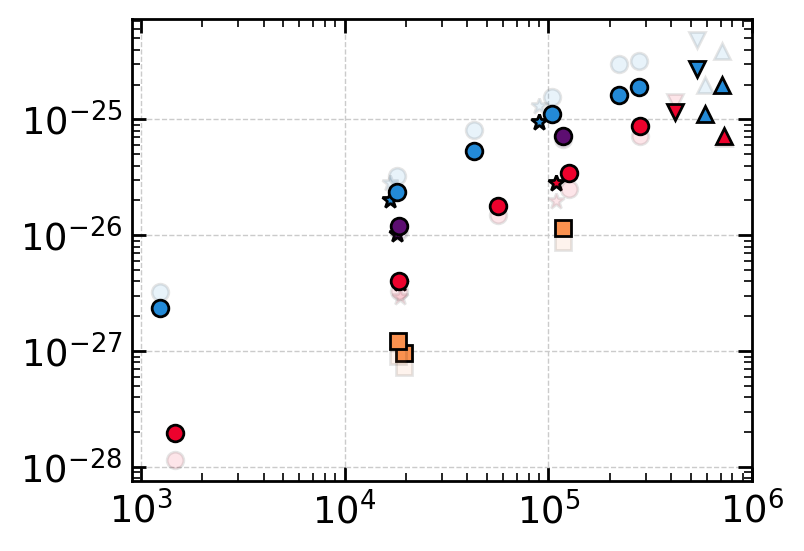

In [20]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)

for m in pdata.mlist:
    print(m)
    if '0.01' in m: continue
    plot_point(pdata,m,'Gamma_PE',phase='Cold',alpha=0.5)
    plot_point(pdata,m,'Gamma_PE',phase='CNM')
plt.xscale('log')
plt.yscale('log')

R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps0.0
R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0
R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg1.Zd1.xy4096.eps0.0
LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0
LGR4_4pc_NCR_S100.full.b1.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8
LGR4_4pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8
LGR4_4pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8


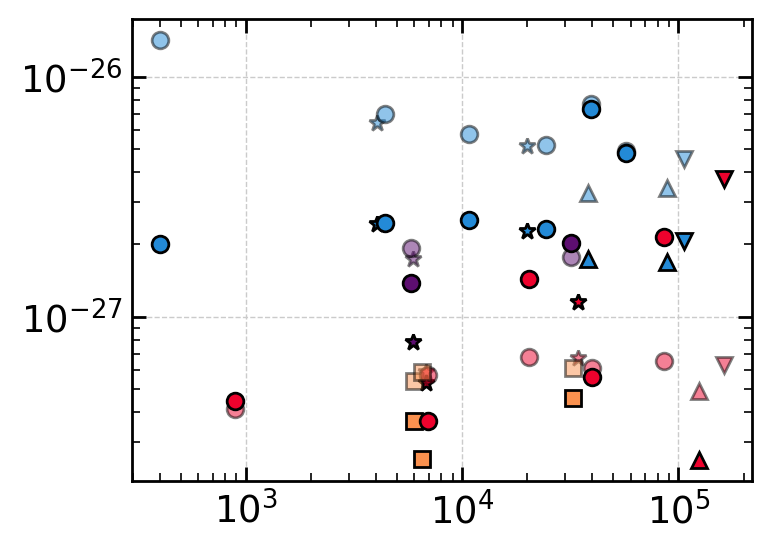

In [21]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)

for m in pdata.mlist:
    print(m)
    if '0.01' in m: continue
    plot_point(pdata,m,'Lambda_CII',xf='Pth',phase='Cold',alpha=0.5)
    plot_point(pdata,m,'Lambda_CII',xf='Pth',phase='CNM')
plt.xscale('log')
plt.yscale('log')

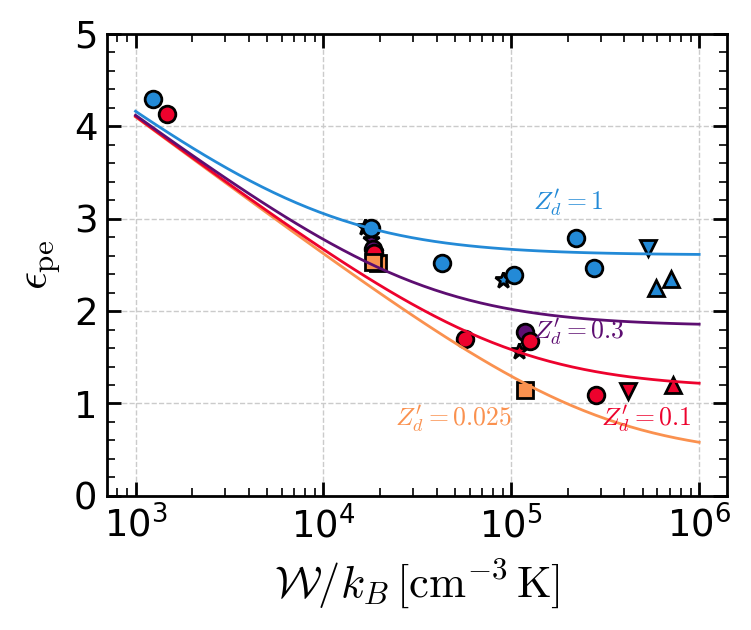

In [17]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
# sm = plt.cm.ScalarMappable(
#     cmap=cmap, norm=Normalize(-1.5, 0,5)
# )
for m in pdata.mlist:
    plot_point(pdata,m,'eps_PE')
    # plt.plot(W.sel(name=dasel.name),dasel2.mean(),marker=marker,color=c,mew=1,mec='k')

plt.annotate(r"$Z_d^\prime=0.025$",(1.e5,1),
             ha='right',va='top',fontsize='xx-small',
             color=cmap(norm(np.log10(0.025))))
plt.annotate(r"$Z_d^\prime=0.1$",(3.e5,1),
             ha='left',va='top',fontsize='xx-small',
             color=cmap(norm(np.log10(0.1))))
plt.annotate(r"$Z_d^\prime=0.3$",(1.3e5,1.6),
             ha='left',va='bottom',fontsize='xx-small',
             color=cmap(norm(np.log10(0.3))))
plt.annotate(r"$Z_d^\prime=1$",(1.3e5,3),
             ha='left',va='bottom',fontsize='xx-small',
             color=cmap(norm(np.log10(1))))
plt.xscale('log')
plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
plt.ylabel(r"$\epsilon_{\rm pe}$")

W_x = np.logspace(3,6)
for Zd in [0.025,0.1,0.3,1]:
    W0 = 1.e4/(Zd+0.01)
    # plt.plot(W_x,1.5*(np.log10((W_x+W0)/(W_x*W0))+3)+4,color=cmap(norm(np.log10(Zd))),lw=1)
    plt.plot(W_x,1.5*np.log10(1e4/W_x+Zd+0.01)+2.6,color=cmap(norm(np.log10(Zd))),lw=1)
plt.savefig(os.path.join(outdir,"eps_PE.png"),bbox_inches='tight')


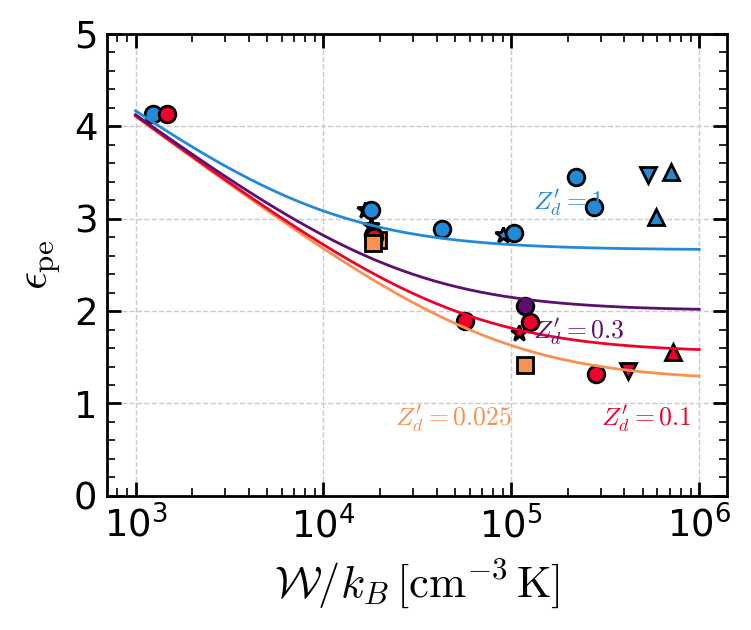

In [18]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
# sm = plt.cm.ScalarMappable(
#     cmap=cmap, norm=Normalize(-1.5, 0,5)
# )
for m in pdata.mlist:
    plot_point(pdata,m,"eps_PE_nchi",phase="2p")

plt.annotate(r"$Z_d^\prime=0.025$",(1.e5,1),
             ha='right',va='top',fontsize='xx-small',
             color=cmap(norm(np.log10(0.025))))
plt.annotate(r"$Z_d^\prime=0.1$",(3.e5,1),
             ha='left',va='top',fontsize='xx-small',
             color=cmap(norm(np.log10(0.1))))
plt.annotate(r"$Z_d^\prime=0.3$",(1.3e5,1.6),
             ha='left',va='bottom',fontsize='xx-small',
             color=cmap(norm(np.log10(0.3))))
plt.annotate(r"$Z_d^\prime=1$",(1.3e5,3),
             ha='left',va='bottom',fontsize='xx-small',
             color=cmap(norm(np.log10(1))))
plt.xscale('log')
plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
plt.ylabel(r"$\epsilon_{\rm pe}$")

W_x = np.logspace(3,6)
for Zd in [0.025,0.1,0.3,1]:
    W0 = 1.e4/(Zd+0.01)
    # plt.plot(W_x,1.5*(np.log10((W_x+W0)/(W_x*W0))+3)+4,color=cmap(norm(np.log10(Zd))),lw=1)
    plt.plot(W_x,1.5*np.log10(1e4/W_x+Zd+0.1)+2.6,color=cmap(norm(np.log10(Zd))),lw=1)
plt.savefig(os.path.join(outdir,"eps_PE_nchi.png"),bbox_inches='tight')


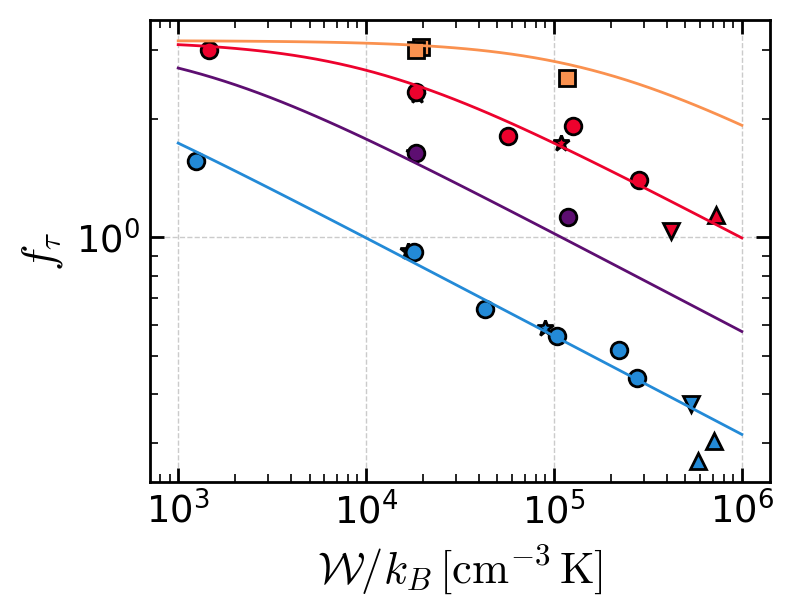

In [19]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
# sm = plt.cm.ScalarMappable(
#     cmap=cmap, norm=Normalize(-1.5, 0,5)
# )
for m in pdata.mlist:
    plot_point(pdata,m,'ftau')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
plt.ylabel(r"$f_\tau$")

W_x = np.logspace(3,6)
for Zd in [0.025,0.1,0.3,1]:
    plt.plot(W_x,(W_x/1.e4*Zd**2+0.01)**(-0.25),color=cmap(norm(np.log10(Zd))),lw=1)
plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')


In [20]:
import astropy.units as au
import astropy.constants as ac
import xarray as xr
import numpy as np

yield_conv = ((au.cm**(-3)*au.K*ac.k_B)/(ac.M_sun/ac.kpc**2/au.yr)).to('km/s').value
Y0=dict(th=414.,turb=615.,mag=481.,nonth=1.23e3)
s1=dict(th=-0.46,turb=-0.22,mag=-0.38,nonth=-0.22)
s2=dict(th=-0.50,turb=0.0,mag=-0.54,nonth=-0.15)

Z=np.logspace(-2,1,300)
W=np.logspace(1,7,600)

Y=xr.Dataset()

Z0=0.0
for c in Y0:
    Y[c] = xr.DataArray(Y0[c]*(W[:,np.newaxis]/1.e4)**s1[c]*(Z[np.newaxis,:]**2+Z0**2)**(s2[c]/2),
                        coords=[W,Z],dims=['W','Z'])

Y['tot'] = Y['th'] + Y['nonth']

In [54]:
def ftau_fit(W,Zd):
    return (W/1.e4*Zd**2+0.01)**(-0.25)
def epe_fit(W,Zd):
    return 1.5*np.log10(1e4/W+Zd+0.01)+2.5
def Y_fit(W,Zd,c,Z0=0.0):
    Y0=dict(th=414.,turb=615.,mag=481.,nonth=1.23e3)
    s1=dict(th=-0.46,turb=-0.22,mag=-0.38,nonth=-0.22)
    s2=dict(th=-0.50,turb=0.0,mag=-0.54,nonth=-0.15)
    return Y0[c]*(W/1.e4)**s1[c]*(Zd**2+Z0**2)**(s2[c]/2)
def SFR_fit(W,Zd):
    yield_conv = ((au.cm**(-3)*au.K*ac.k_B)/(ac.M_sun/ac.kpc**2/au.yr)).to('km/s').value
    Ytot = Y_fit(W,Zd,'th') + Y_fit(W,Zd,'nonth')
    Ytot /= yield_conv
    return W/Ytot
def n_fit(W,Zd):
    return (W/1.5e4)**(1/1.2)
def PE_fit(W,Zd):
    ftau = ftau_fit(W,Zd)
    epe = epe_fit(W,Zd)
    SFR = SFR_fit(W,Zd)
    n_cold = n_fit(W,Zd)*2
    return n_cold*1.7e-26*(SFR/2.5e-3)*ftau*epe*Zd
def Sigma_fit(W,Zd):
    NH = n_fit(W,Zd)*250*ac.pc.cgs.value/(W/2.e4)**0.35
    return NH/((ac.M_sun / ac.pc**2) / (1.4 * ac.m_p)).cgs.value
def CR_fit(W,Zd):
    SFR = SFR_fit(W,Zd)
    Sigma = Sigma_fit(W,Zd)
    ne = 1.e-2*n_fit(W,Zd)
    xi_CR = 2.e-16*(SFR/2.5e-3)*(10/Sigma)
    return ne*xi_CR*5.e-9
def Lmetal_fit(W,Zg):
    return 1.e-25*Zg*n_fit(W_x,Zg)**2



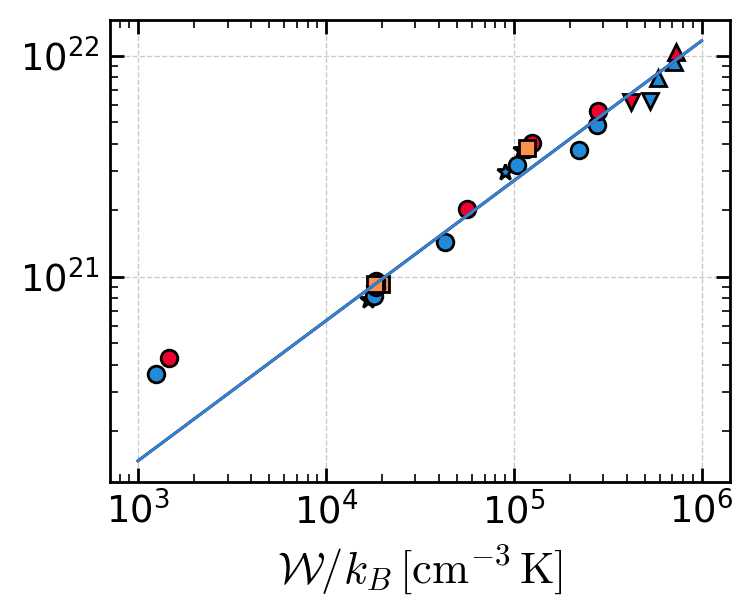

In [22]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    plot_point(pdata,m,'NH')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

W_x = np.logspace(3,6)
for Zd in [0.025,0.1,0.3,1]:
    plt.plot(W_x,n_fit(W_x,Zd)*250*ac.pc.cgs.value/(W_x/2.e4)**0.2,lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

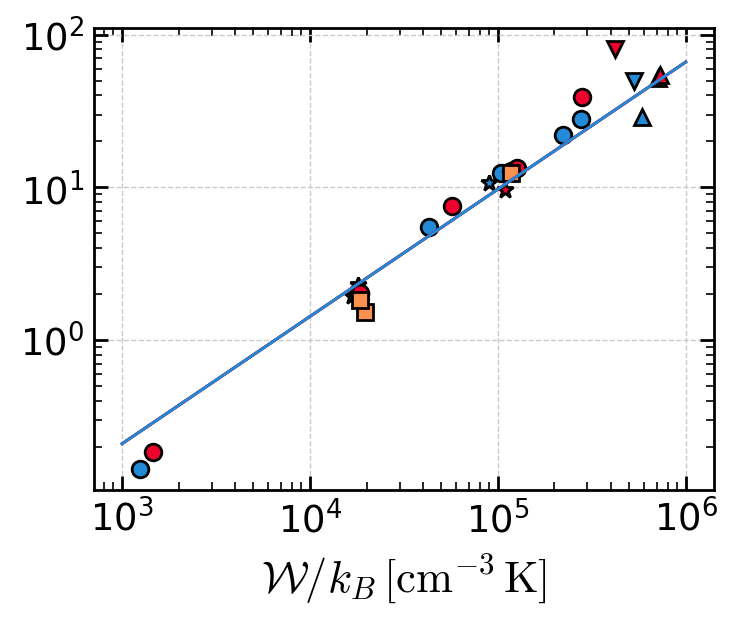

In [23]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    plot_point(pdata,m,'nH',weight='volume',phase='Cold')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

W_x = np.logspace(3,6)
for Zd in [0.025,0.1,0.3,1]:
    plt.plot(W_x,2*n_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

Text(0.5, 0, '$\\mathcal{W}$$/k_B\\,[{\\rm cm^{-3}\\,K}]$')

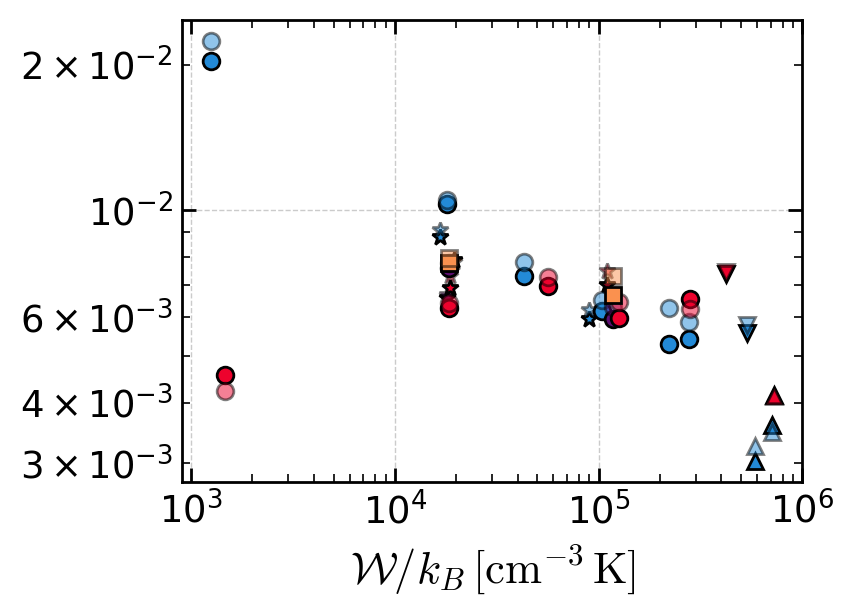

In [24]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    W, xe, kwargs = get_point(pdata,m,'xe',weight='mass',phase='Cold')
    W, ne, kwargs = get_point(pdata,m,'ne',weight='volume',phase='Cold')
    W, nH, kwargs = get_point(pdata,m,'nH',weight='volume',phase='Cold')
    plt.plot(W, xe.median(),**kwargs)
    plt.plot(W, ne.median()/nH.median(),alpha=0.5,**kwargs)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

# W_x = np.logspace(3,6)
# for Zd in [0.025,0.1,0.3,1]:
#     plt.plot(W_x,1.e-2*n_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

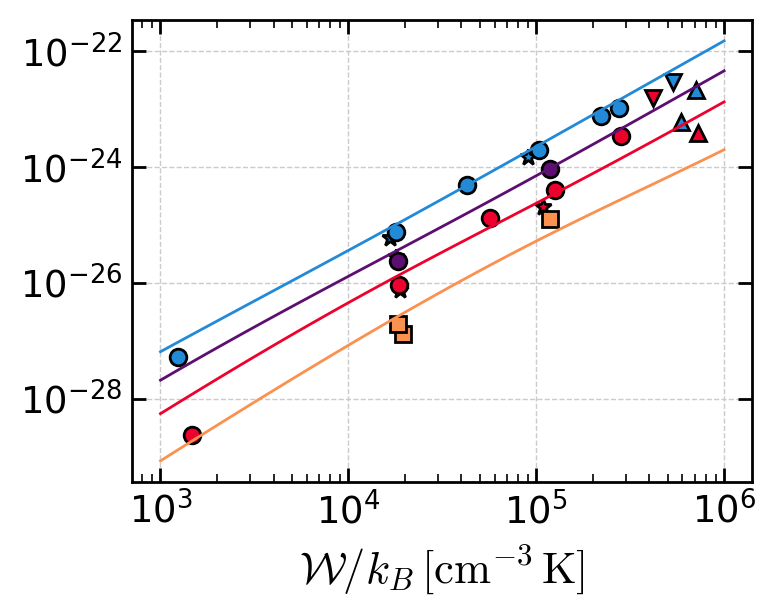

In [25]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    plot_point(pdata,m,'PE',weight='volume',phase='Cold')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

W_x = np.logspace(3,6)
for Zd in [0.025,0.1,0.3,1]:
    plt.plot(W_x,PE_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

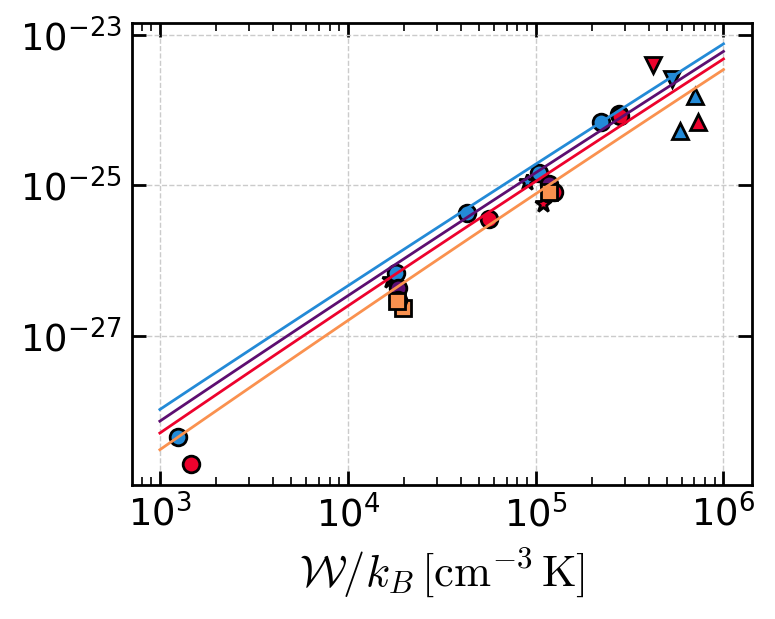

In [26]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    plot_point(pdata,m,'CR',weight='volume',phase='Cold')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

W_x = np.logspace(3,6)
for Zd in [0.025,0.1,0.3,1]:
    plt.plot(W_x,CR_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

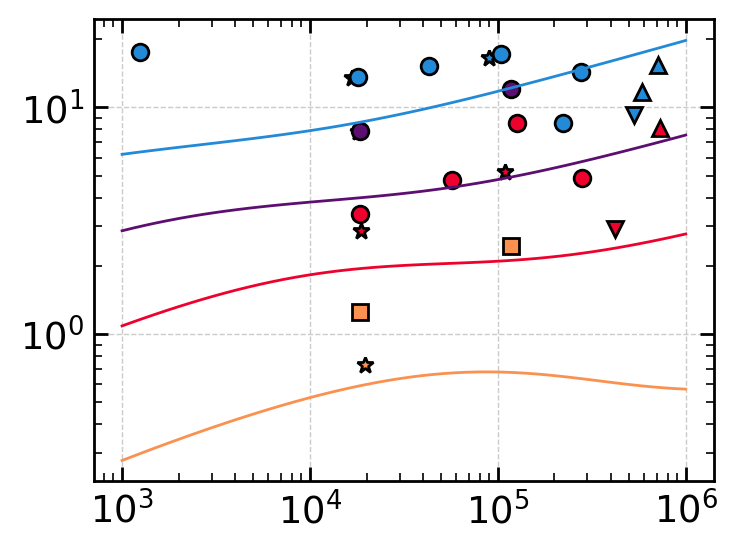

In [27]:
fig = plt.figure(figsize=(4,3))

for m in pdata.mlist:
    W, PE, kwargs = get_point(pdata,m,'PE',phase='Cold')
    W, CR, kwargs = get_point(pdata,m,'CR',phase='Cold')
    plt.plot(W,PE.median()/CR.median(),**kwargs)
W_x = np.logspace(3,6)
for Zd in [0.025,0.1,0.3,1]:
    plt.plot(W_x,PE_fit(W_x,Zd)/CR_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
plt.xscale('log')
plt.yscale('log')

Text(0.5, 0, '$\\mathcal{W}$$/k_B\\,[{\\rm cm^{-3}\\,K}]$')

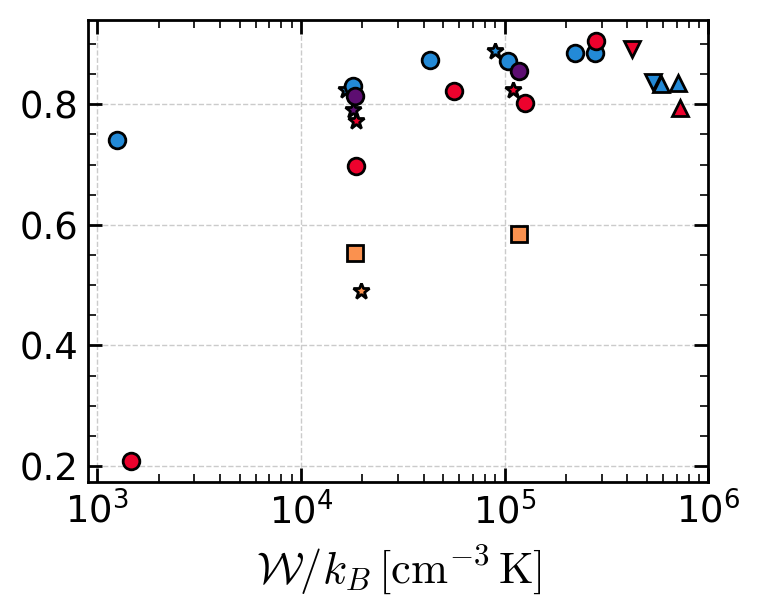

In [28]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    W, heat, kwargs = get_point(pdata,m,'heat_rate',weight='volume',phase='Cold')
    W, cool, kwargs = get_point(pdata,m,'cool_rate',weight='volume',phase='Cold')
    plt.plot(W,heat.median()/cool.median(),**kwargs)
plt.xscale('log')
# plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

# W_x = np.logspace(3,6)
# for Zd in [0.025,0.1,0.3,1]:
#     plt.plot(W_x,PE_fit(W_x,Zd)+CR_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

In [29]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    W, OI, kwargs = get_point(pdata,m,'CII',weight='volume',phase='Cold')
    W, CII, kwargs = get_point(pdata,m,'OI',weight='volume',phase='Cold')
    metal = CII + OI
    W, cool, kwargs = get_point(pdata,m,'cool_rate',weight='volume',phase='Cold')
    cool*=unit_cooling_rate
    plt.plot(W,metal.where(cool>0).median()/cool.where(cool>0).median(),**kwargs)
plt.xscale('log')
# plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

# W_x = np.logspace(3,6)
# for Zd in [0.025,0.1,0.3,1]:
#     plt.plot(W_x,PE_fit(W_x,Zd)+CR_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

NameError: name 'unit_cooling_rate' is not defined

<Figure size 800x600 with 0 Axes>

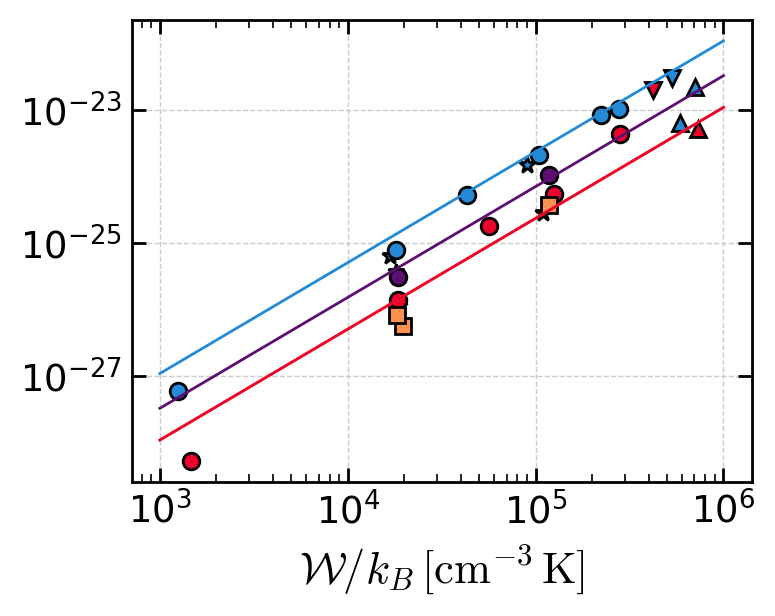

In [ ]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    plot_point(pdata,m,'metal',weight='volume',phase='Cold')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

W_x = np.logspace(3,6)
for Zd,Zg in zip([0.025,0.1,0.3,1],[0.1,0.1,0.3,1]):
    plt.plot(W_x,1.e-25*Zg*n_fit(W_x,Zg)**2,lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

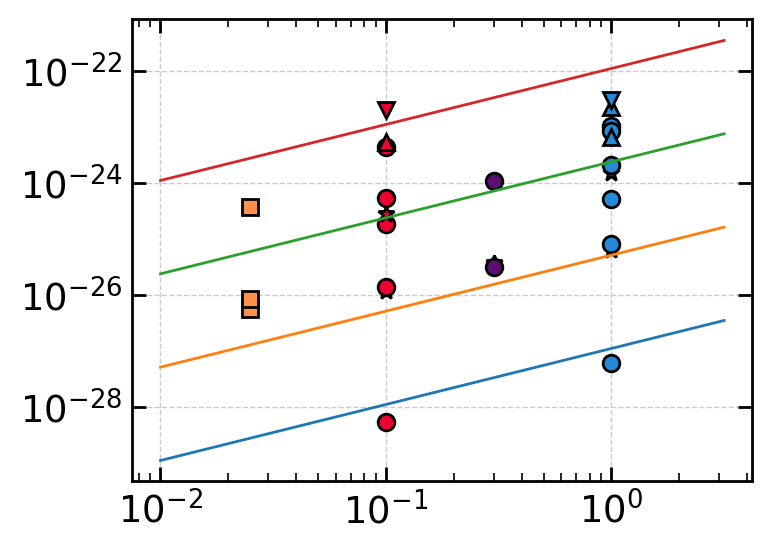

In [ ]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    plot_point(pdata,m,'metal',xf='Zdust',weight='volume',phase='Cold')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
# plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

# W_x = np.logspace(3,6)
Zg = np.logspace(-2,0.5)
for W_x in [1.e3,1.e4,1.e5,1.e6]:
# for Zd,Zg in zip([0.025,0.1,0.3,1],[0.1,0.1,0.3,1]):
    # plt.plot(W_x,1.e-25*Zg*n_fit(W_x,Zg)**2,lw=1,color=cmap(norm(np.log10(Zd))))
    plt.plot(Zg,1.e-25*Zg*n_fit(W_x,Zg)**2,lw=1)
#     plt.plot(W_x,1.e-25*Zg*n_fit(W_x,Zg)**2,lw=1,color=cmap(norm(np.log10(Zd))))

# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

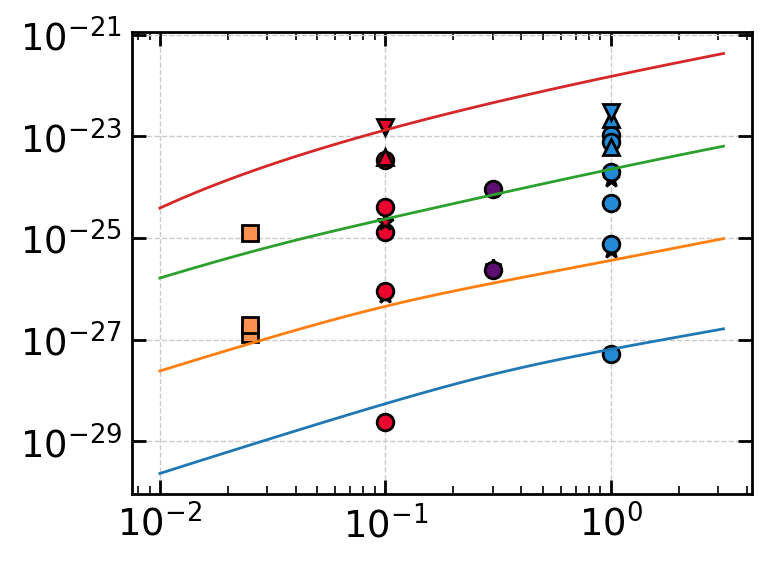

In [ ]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    plot_point(pdata,m,'PE',xf='Zdust',weight='volume',phase='Cold')
    # plot_point(pdata,m,'PE',xf='Zdust',weight='volume',phase='CNM',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
# plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

# W_x = np.logspace(3,6)
Zg = np.logspace(-2,0.5)
for W_x in [1.e3,1.e4,1.e5,1.e6]:
# for Zd,Zg in zip([0.025,0.1,0.3,1],[0.1,0.1,0.3,1]):
    # plt.plot(W_x,1.e-25*Zg*n_fit(W_x,Zg)**2,lw=1)
    plt.plot(Zg,PE_fit(W_x,Zg),lw=1)
#     plt.plot(W_x,1.e-25*Zg*n_fit(W_x,Zg)**2,lw=1,color=cmap(norm(np.log10(Zd))))

# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

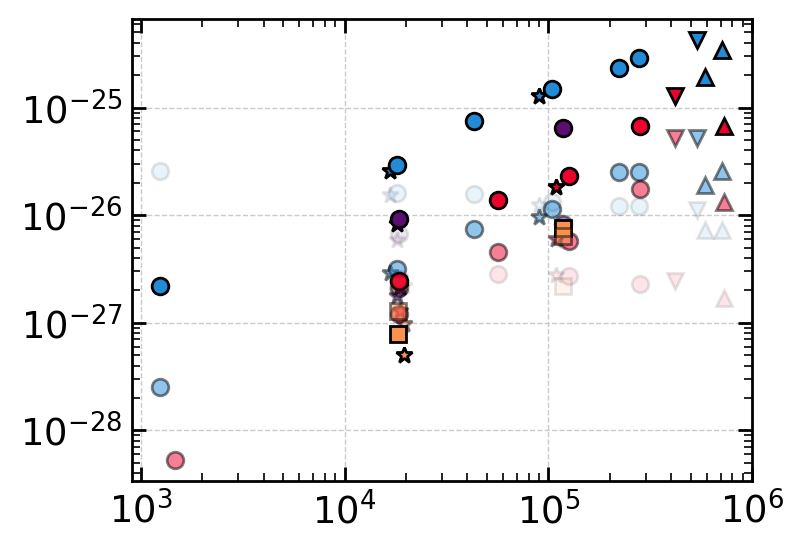

In [68]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    W, PE, kwargs = get_point(pdata,m,'PE',weight='volume',phase='Cold')
    W, CR, kwargs = get_point(pdata,m,'CR',weight='volume',phase='Cold')
    W, nH, kwargs = get_point(pdata,m,'nH',weight='volume',phase='Cold')

    Gamma_PE = PE.median()/nH.median()
    Gamma_CR = CR.median()/nH.median()

    plt.plot(W,Gamma_PE,**kwargs)
    plt.plot(W,Gamma_CR,**kwargs,alpha=0.5)
    W, OI, kwargs = get_point(pdata,m,'CII',weight='volume',phase='Cold')
    W, CII, kwargs = get_point(pdata,m,'OI',weight='volume',phase='Cold')
    W, nH_m, kwargs = get_point(pdata,m,'nH',weight='mass',phase='Cold')

    metal = CII + OI
    n2 = nH*nH

    Lambda_metal = metal.median()/n2.median()
    plt.plot(W,Lambda_metal,**kwargs,alpha=0.1)
    # plot_point(pdata,m,'PE',xf='Zdust',weight='volume',phase='CNM',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
# plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

# W_x = np.logspace(3,6)
# Zg = np.logspace(-2,0.5)
# for W_x in [1.e3,1.e4,1.e5,1.e6]:
# for Zd,Zg in zip([0.025,0.1,0.3,1],[0.1,0.1,0.3,1]):
    # plt.plot(W_x,Gamma_PE_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
    # plt.plot(W_x,Lambda_metal_fit(W_x,Zd)/20,lw=1,color=cmap(norm(np.log10(Zd))))
    # plt.plot(Zg,PE_fit(W_x,Zg),lw=1)
#     plt.plot(W_x,1.e-25*Zg*n_fit(W_x,Zg)**2,lw=1,color=cmap(norm(np.log10(Zd))))

# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

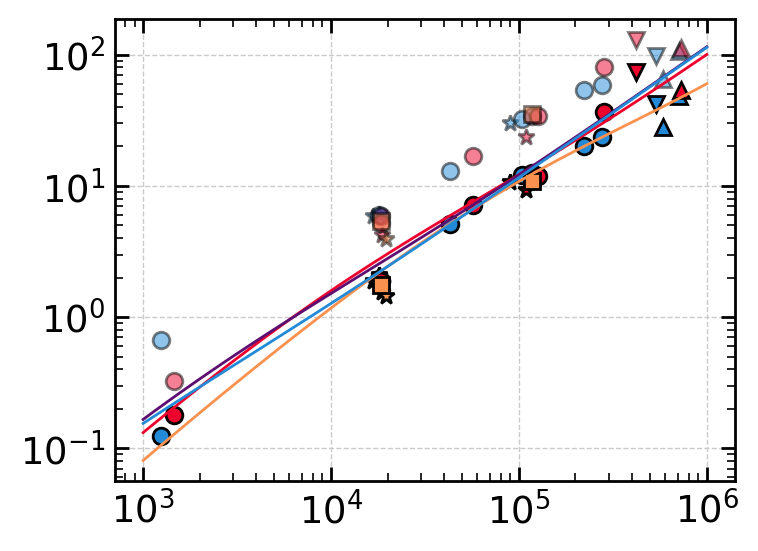

In [30]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    W, PE, kwargs = get_point(pdata,m,'PE',weight='volume',phase='Cold')
    W, nH, kwargs = get_point(pdata,m,'nH',weight='volume',phase='Cold')

    Gamma_PE = PE.median()/nH.median()

    plt.plot(W,nH.median(),**kwargs)
    W, OI, kwargs = get_point(pdata,m,'CII',weight='volume',phase='Cold')
    W, CII, kwargs = get_point(pdata,m,'OI',weight='volume',phase='Cold')
    W, nH_m, kwargs = get_point(pdata,m,'nH',weight='mass',phase='Cold')

    metal = CII + OI
    n2 = nH*nH_m

    Lambda_metal = metal.median()/n2.median()
    plt.plot(W,nH_m.median(),**kwargs,alpha=0.5)
    # plot_point(pdata,m,'PE',xf='Zdust',weight='volume',phase='CNM',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
# plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

W_x = np.logspace(3,6)
# Zg = np.logspace(-2,0.5)
# for W_x in [1.e3,1.e4,1.e5,1.e6]:
for Zd,Zg in zip([0.025,0.1,0.3,1],[0.1,0.1,0.3,1]):
    plt.plot(W_x,Gamma_PE_fit(W_x,Zd)/Lambda_metal_fit(W_x,Zd)*5,lw=1,color=cmap(norm(np.log10(Zd))))
    # plt.plot(W_x,,lw=1,color=cmap(norm(np.log10(Zd))))
    # plt.plot(Zg,PE_fit(W_x,Zg),lw=1)
#     plt.plot(W_x,1.e-25*Zg*n_fit(W_x,Zg)**2,lw=1,color=cmap(norm(np.log10(Zd))))

# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

In [ ]:

def Gamma_PE_fit(W,Zd):
    ftau = ftau_fit(W,Zd)
    epe = epe_fit(W,Zd)
    # SFR = SFR_fit(W,Zd)
    return 1.7e-26*ftau*epe*Zd/2.5e-3

def Gamma_CR_fit(W,Zd):
    Sigma = Sigma_fit(W,Zd)
    xi_CR = 2.e-16*(10/Sigma)
    return xi_CR*5.e-9*1.e-2/2.5e-3
def Lambda_metal_fit(W,Zg):
    return 1.e-25*Zg*W/W

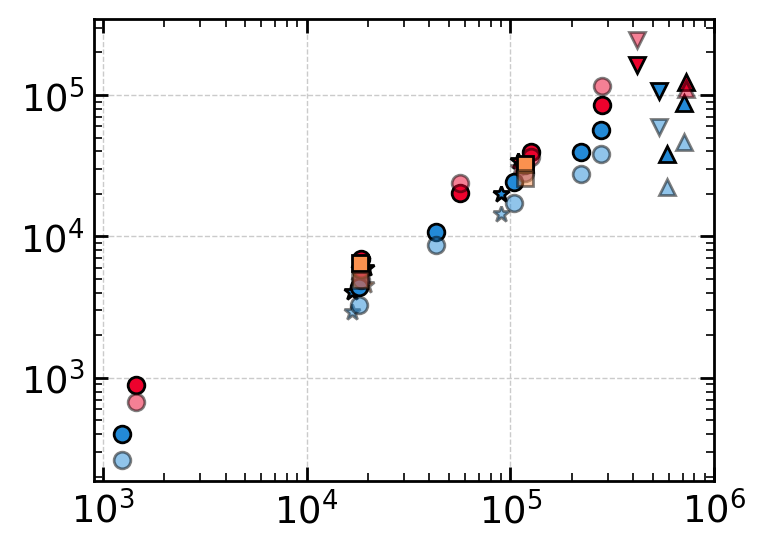

In [107]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    Pth, PE, kwargs = get_point(pdata,m,'PE',xf='Pth',weight='volume',phase='Cold')
    W, nH, kwargs = get_point(pdata,m,'nH',weight='volume',phase='Cold')
    W, T, kwargs = get_point(pdata,m,'T',weight='mass',phase='Cold')
    plt.plot(W,Pth,**kwargs)
    plt.plot(W,(nH*T).mean(),**kwargs,alpha=0.5)
    # plot_point(pdata,m,'PE',xf='Zdust',weight='volume',phase='CNM',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
# plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

# W_x = np.logspace(3,6)
# for Zd,Zg in zip([0.025,0.1,0.3,1],[0.1,0.1,0.3,1]):
#     plt.plot(W_x,Gamma_PE_fit(W_x,Zd)/Lambda_metal_fit(W_x,Zg)*5*1500/(Zg)**0.3*yield_conv,lw=1,color=cmap(norm(np.log10(Zd))),ls='--')
#     plt.plot(W_x,Gamma_CR_fit(W_x,Zd)/Lambda_metal_fit(W_x,Zg)*5*1500/(Zg)**0.3*yield_conv,lw=1,color=cmap(norm(np.log10(Zd))),ls=':')
#     plt.plot(W_x,(Gamma_PE_fit(W_x,Zd)+Gamma_CR_fit(W_x,Zd))/Lambda_metal_fit(W_x,Zg)*5*1500/(Zg)**0.3*yield_conv,lw=1,color=cmap(norm(np.log10(Zd))))

#     # plt.plot(W_x,,lw=1,color=cmap(norm(np.log10(Zd))))
#     # plt.plot(Zg,PE_fit(W_x,Zg),lw=1)
# #     plt.plot(W_x,1.e-25*Zg*n_fit(W_x,Zg)**2,lw=1,color=cmap(norm(np.log10(Zd))))

# # plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

Text(0.5, 0, '$\\mathcal{W}$$/k_B\\,[{\\rm cm^{-3}\\,K}]$')

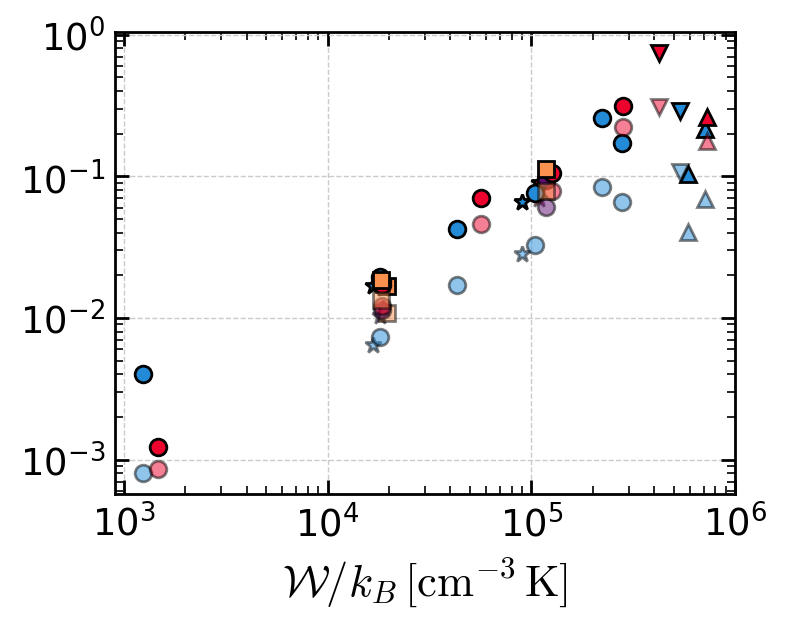

In [183]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    plot_point(pdata,m,'ne',phase='CNM',alpha=0.5)
    plot_point(pdata,m,'ne',phase='Cold')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

# W_x = np.logspace(3,6)
# for Zd in [0.025,0.1,0.3,1]:
#     plt.plot(W_x,PE_fit(W_x,Zd)+CR_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

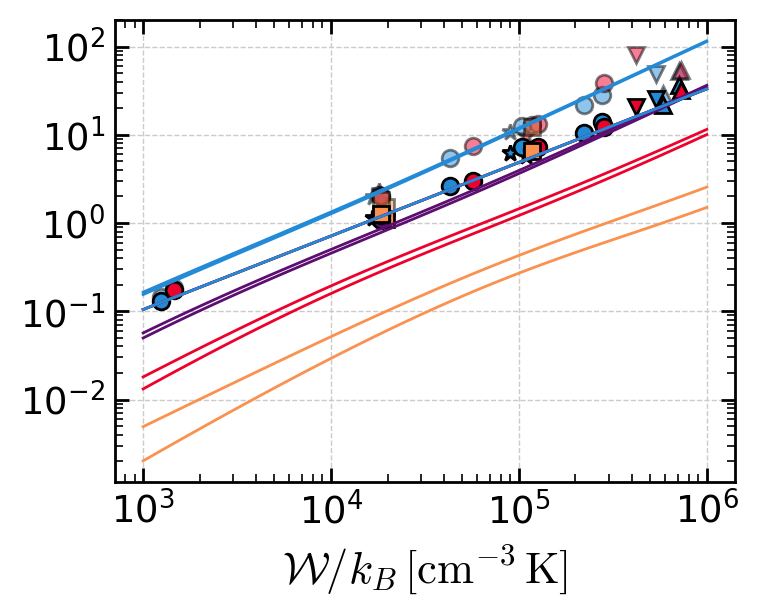

In [110]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    plot_point(pdata,m,'nH',weight='volume',phase='Cold',alpha=0.5)
    plot_point(pdata,m,'nH',weight='volume',phase='2p')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

W_x = np.logspace(3,6)
Lambda_metal0=2.e-26
Gamma_PE0=1.7e-26
Gamma_CR0=2.e-27
for Zd in [0.025,0.1,0.3,1]:
    Gamma_PE = Gamma_PE0*ftau_fit(W_x,Zd)*epe_fit(W_x,Zd)*SFR_fit(W_x,Zd)/2.5e-3*Zd
    Gamma_CR = Gamma_CR0*SFR_fit(W_x,Zd)/2.5e-3*(10/Sigma_fit(W_x,Zd))
    Gamma = Gamma_PE+Gamma_CR
    plt.plot(W_x,n_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
    plt.plot(W_x,Gamma_PE/(Lambda_metal0*Zg),lw=1,color=cmap(norm(np.log10(Zd))))
    plt.plot(W_x,Gamma/(Lambda_metal0*Zg),lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

Text(0.5, 0, '$\\mathcal{W}$$/k_B\\,[{\\rm cm^{-3}\\,K}]$')

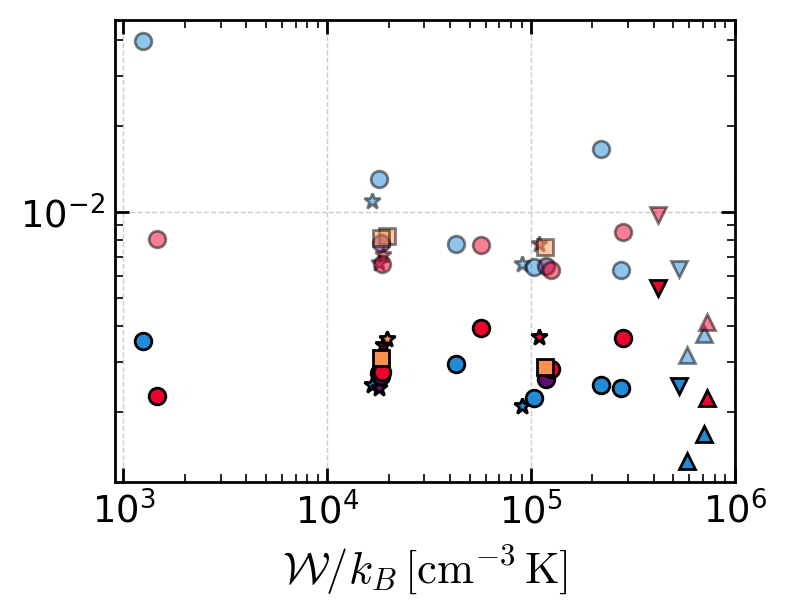

In [186]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    W, ne, kwargs = get_point(pdata,m,'ne',phase='Cold')
    W, nH, kwargs = get_point(pdata,m,'nH',phase='Cold')
    plt.plot(W,ne.median()/nH.median(),**kwargs)
    plot_point(pdata,m,'xe',phase='Cold',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

# W_x = np.logspace(3,6)
# for Zd in [0.025,0.1,0.3,1]:
#     plt.plot(W_x,PE_fit(W_x,Zd)+CR_fit(W_x,Zd),lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

In [195]:
np.exp(-92/3000)

0.9697987854661236

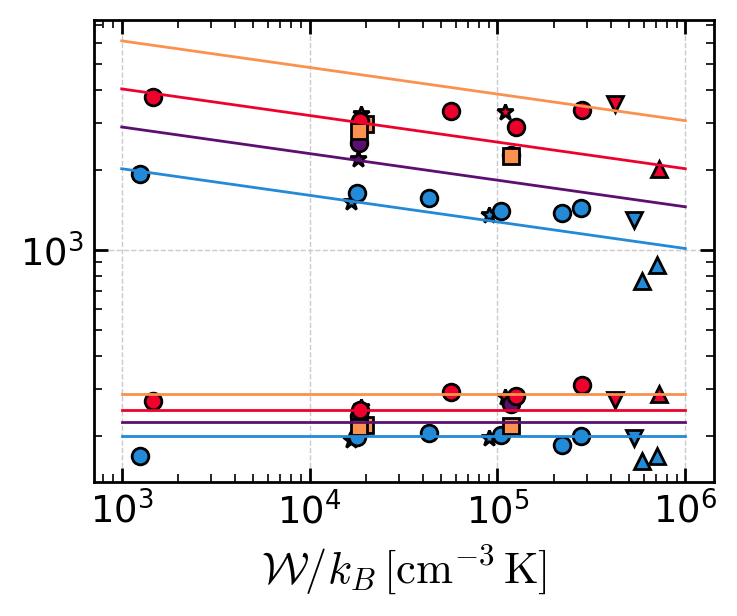

In [87]:
fig = plt.figure(figsize=(4,3))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    plot_point(pdata,m,'T',weight='mass',phase='CNM')
    plot_point(pdata,m,'T',weight='mass',phase='Cold')
plt.xscale('log')
plt.yscale('log')
# plt.ylim(0,5)
plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
# plt.ylabel(r"$f_\tau$")

W_x = np.logspace(3,6)
for Zd in [0.025,0.1,0.3,1]:
    plt.plot(W_x,1.5e3/Zd**0.3*(W_x/2.e4)**(-0.1),lw=1,color=cmap(norm(np.log10(Zd))))
    plt.plot(W_x,2.e2/Zd**0.1*(W_x/2.e4)**(0.0),lw=1,color=cmap(norm(np.log10(Zd))))
# plt.savefig(os.path.join(outdir,"f_tau.png"),bbox_inches='tight')

In [69]:

def Gamma_PE_fit(W,Zd):
    ftau = ftau_fit(W,Zd)
    epe = epe_fit(W,Zd)
    # SFR = SFR_fit(W,Zd)
    return 1.7e-26*ftau*epe*Zd/2.5e-3

def Gamma_CR_fit(W,Zd):
    Sigma = Sigma_fit(W,Zd)
    xi_CR = 2.e-16*(10/Sigma)
    return xi_CR*5.e-9*1.e-2/2.5e-3
def Lambda_metal_fit(W,Zg):
    return 1.e-25*Zg*W/W



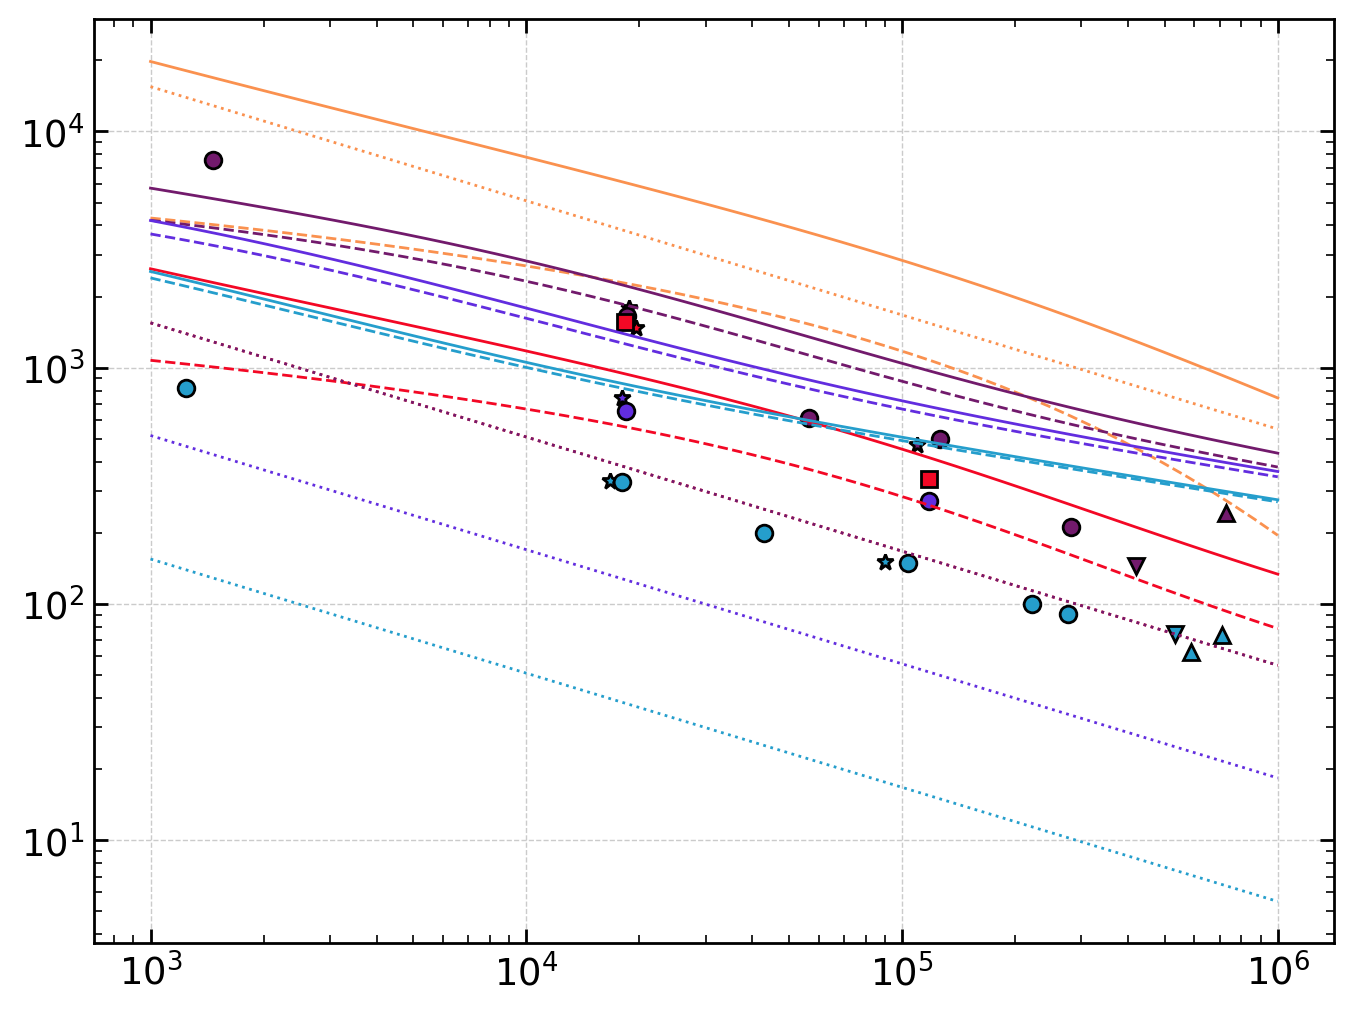

In [97]:

cmap=cmr.guppy
Zmin=-2
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
for m in pdata.mlist:
    W, PE, kwargs = get_point(pdata,m,'PE',xf='W',weight='volume',phase='Cold')
    Yth, PE, kwargs = get_point(pdata,m,'PE',xf='Yth',weight='volume',phase='Cold')
    plt.plot(W,Yth,**kwargs)

W_x = np.logspace(3,6)
for Zd,Zg in zip([0.01,0.025,0.1,0.3,1],[0.01,0.1,0.1,0.3,1]):
    # plt.plot(W_x,Gamma_PE0*Zd/(Lambda_metal0*Zg)*W_x/W_x,
    #          lw=1,color=cmap(norm(np.log10(Zd))))
    Gamma_PE = Gamma_PE0*ftau_fit(W_x,Zd)*epe_fit(W_x,Zd)*Zd
    Gamma_CR = Gamma_CR0*(10/Sigma_fit(W_x,Zd))
    Gamma = Gamma_PE+Gamma_CR
    Lambda_metal = Lambda_metal0*Zg*W_x/W_x
    T = 200
    plt.plot(W_x,Gamma_CR/Lambda_metal*T,
             lw=1,color=cmap(norm(np.log10(Zd))),ls=':')
    plt.plot(W_x,Gamma_PE/Lambda_metal*T,
             lw=1,color=cmap(norm(np.log10(Zd))),ls='--')
    plt.plot(W_x,Gamma/Lambda_metal*T,
             lw=1,color=cmap(norm(np.log10(Zd))),ls='-')
plt.yscale('log')
plt.xscale('log')

In [93]:
Labmda_metal

array([1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28,
       1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28,
       1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28,
       1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28,
       1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28,
       1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28, 1.e-28,
       1.e-28, 1.e-28])

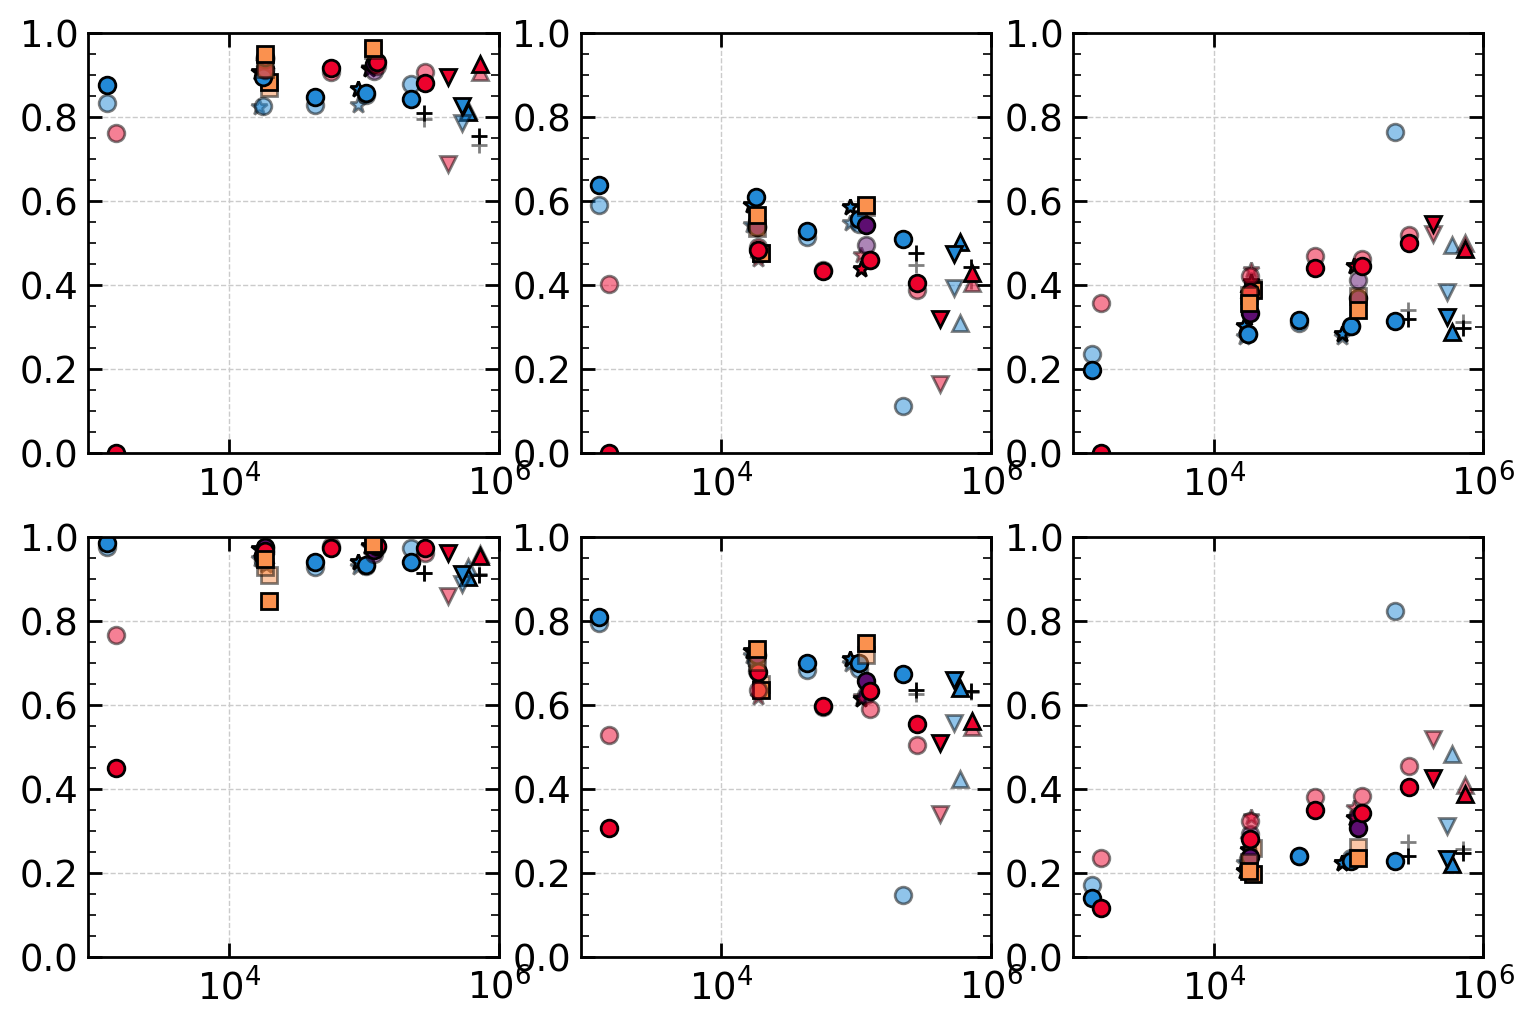

In [121]:
fig,axes_ = plt.subplots(2,3,figsize=(9,6))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
unit_cooling_rate=(s.u.energy_density / s.u.time).cgs.value

for ph,axes in zip(['Cold','CNM'],axes_):
    for m in pdata.mlist:
        s = pdata.sa.set_model(m)
        da,ds1,ds2 = construct_timeseries(pdata,m,force_override=False)
        torb = s.torb_Myr/s.u.Myr
        if s.torb_Myr <50:
            trange = slice(torb*5,torb*15)
        elif s.torb_Myr >300:
            trange = slice(torb*1.5,torb*5)
        else:
            trange = slice(torb*2,torb*5)

        # if m == 'LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8':
        #     trange = slice(torb*1.5,torb*3.3)
        cool_metal = (ds2['CI']+ds2['CII']+ds2['OI']).sel(phase=ph).sel(time=trange)
        cool_CII = (ds2['CII']).sel(phase=ph).sel(time=trange)
        cool_OI = (ds2['OI']).sel(phase=ph).sel(time=trange)
        cool_neb = (ds2['neb']).sel(phase=ph).sel(time=trange)
        cool_Lya = (ds2['HI_Lya']).sel(phase=ph).sel(time=trange)
        cool_H2 = (ds2['H2_rovib']+ds2['H2_colldiss']).sel(phase=ph).sel(time=trange)
        cool_gr = (ds2['grRec']+ds2['H2_colldiss']).sel(phase=ph).sel(time=trange)
        cool_total = (ds2['cool_rate']*unit_cooling_rate).sel(phase=ph).sel(time=trange)

        name = da.name
        if 'Zd0.025' in name:
            marker='s'
        elif 'Om01' in name:
            marker='v'
        elif 'Om02' in name:
            marker='^'
        elif 'b10' in name and not 'S05' in name:
            marker='*'
        else:
            marker='o'
        c = cmap(norm(np.log10(s.Zdust)))

        if 'r' in name:
            marker='+'
        for ax,cool_comp in zip(axes,[cool_metal,cool_CII,cool_OI]):
            plt.sca(ax)
            plt.plot(W.sel(name=da.name),cool_comp.mean()/cool_total.mean(),
                    marker=marker,color=c,mew=1,mec='k',alpha=0.5)
            plt.plot(W.sel(name=da.name),cool_comp.median()/cool_total.median(),
                    marker=marker,color=c,mew=1,mec='k')
            plt.xscale('log')
            # plt.yscale('log')
            plt.ylim(0,1)
        # plt.plot(W.sel(name=da.name),cool_total.mean(),marker=marker,color=c)


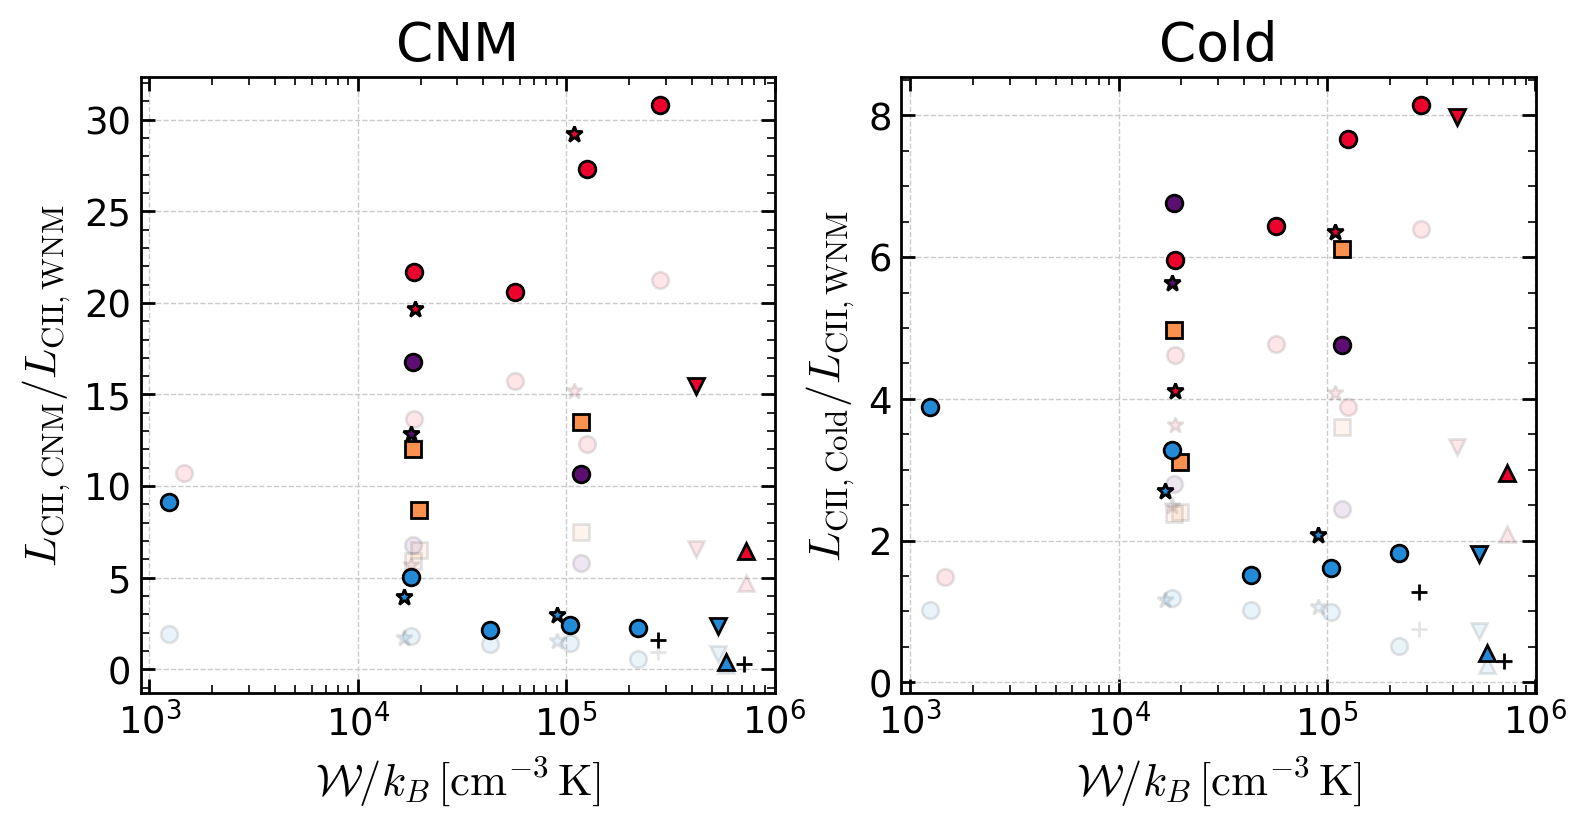

In [91]:
fig,axes = plt.subplots(1,2,figsize=(9,4))
cmap=cmr.guppy
Zmin=-1.3
Zmax=0.3
norm = Normalize(vmin=Zmin, vmax=Zmax)
unit_cooling_rate=(s.u.energy_density / s.u.time).cgs.value


for m in pdata.mlist:
    s = pdata.sa.set_model(m)
    da,ds1,ds2 = construct_timeseries(pdata,m,force_override=False)
    torb = s.torb_Myr/s.u.Myr
    if s.torb_Myr <50:
        trange = slice(torb*5,torb*15)
    elif s.torb_Myr >300:
        trange = slice(torb*1.5,torb*5)
    else:
        trange = slice(torb*2,torb*5)

    name = da.name
    if 'Zd0.025' in name:
        marker='s'
    elif 'Om01' in name:
        marker='v'
    elif 'Om02' in name:
        marker='^'
    elif 'b10' in name and not 'S05' in name:
        marker='*'
    else:
        marker='o'
    c = cmap(norm(np.log10(s.Zdust)))

    if 'r' in name:
        marker='+'
    for ax,ph in zip(axes,['CNM','Cold']):
        plt.sca(ax)
        plt.plot(W.sel(name=da.name),
                 ds2['CII'].sel(phase=ph).mean()/ds2['CII'].sel(phase='WNM').mean(),
                 marker=marker,color=c,mew=1,mec='k',alpha=0.1)
        plt.plot(W.sel(name=da.name),
                 ds2['CII'].sel(phase=ph).median()/ds2['CII'].sel(phase='WNM').median(),
                 marker=marker,color=c,mew=1,mec='k')

        plt.xscale('log')
        plt.title(ph)
        plt.ylabel(f'$L_{{\\rm CII,{ph}}}/L_{{\\rm CII,WNM}}$')
        plt.xlabel(r"$\mathcal{W}$"+r"$/k_B\,[{\rm cm^{-3}\,K}]$")
        # plt.yscale('log')
        # plt.ylim(0,1)
    # plt.plot(W.sel(name=da.name),cool_total.mean(),marker=marker,color=c)


In [3]:
qdset

NameError: name 'qdset' is not defined

['R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps0.0',
 'R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps0.0',
 'R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0',
 'R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0',
 'R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0',
 'R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0',
 'R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0',
 'R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0',
 'R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0',
 'R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0',
 'LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg1.Zd1.xy4096.eps0.0',
 'LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0',
 'LGR4_4pc_NCR_S100.full.b1.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01',
 'LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8',
 'LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8',
 'LGR4_4pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8',
 'LGR4_4pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy2

In [76]:
m='LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8'
m='LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0'
s = pdata.sa.set_model(m)
da,ds1,ds2 = construct_timeseries(pdata,m,force_override=False)
torb = s.torb_Myr/s.u.Myr
if s.torb_Myr <50:
    trange = slice(torb*5,torb*15)
elif s.torb_Myr >300:
    trange = slice(torb*1.5,torb*5)
else:
    trange = slice(torb*1.5,torb*3.5)

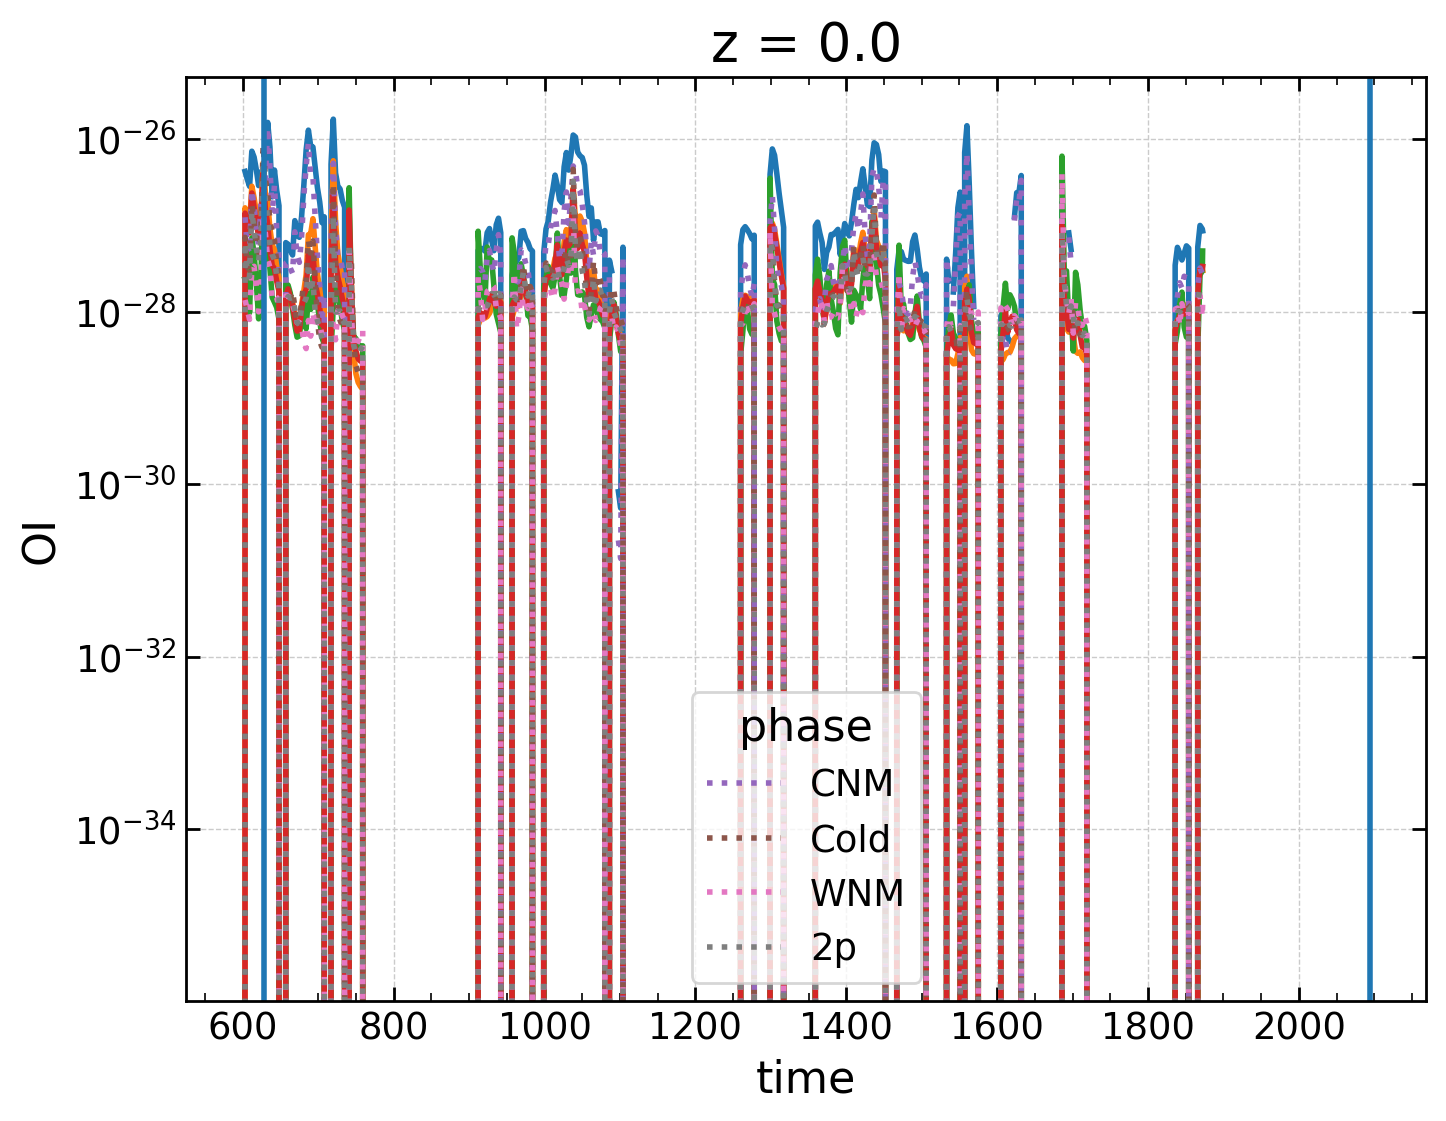

In [78]:
ds2['CII'].plot(hue='phase')
ds2['OI'].plot(hue='phase',ls=':')
plt.axvline(trange.start)
plt.axvline(trange.stop)
plt.yscale('log')
# plt.ylim(1.e-25,1.e-19)

NameError: name 'ds1' is not defined

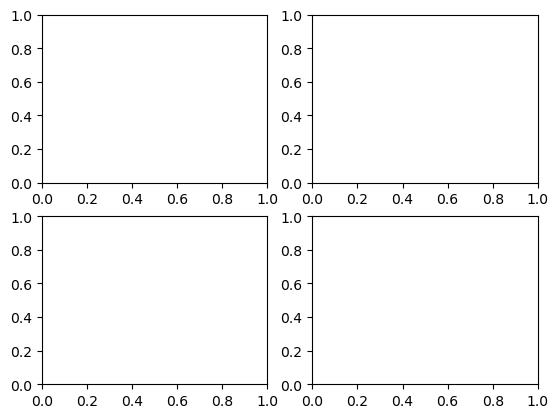

In [2]:
fig,axes = plt.subplots(2,2)
for ax,ph in zip(axes.flatten(),list(ds1['phase'])):
    plt.sca(ax)
    (ds1['heat_rate']*unit_cooling_rate).sel(phase=ph).plot()
    ds1['PE'].sel(phase=ph).plot()
    ds1['CR'].sel(phase=ph).plot()
    # ds1['PH'].sel(phase='2p').plot()
    plt.yscale('log')

In [154]:
from fitting_scripts import *

In [158]:
# We are fitting variables as a function of "W" and "Zgas"
# I set the parameter range of interest (in log scale) here
Zmin=-1.3
Zmax=0.3
Wmin=2.7
Wmax=6.3

In [159]:
x1,x2=['W','Zgas']
yf='Yth'
# linear regression
odr_out = fit_odr(qdset,xf1=x1,xf2=x2,yf=yf)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset = get_model_odr(odr_out,Zmin=Zmin,Zmax=Zmax,Wmin=Wmin,Wmax=Wmax,dims=[x2,x1])

Beta: [ 4.77950412 -0.52648525 -0.59328964]
Beta Std Error: [0.15702443 0.03128173 0.04920877]
Beta Covariance: [[ 2.94562411 -0.57264484  0.24605037]
 [-0.57264484  0.11690266 -0.01976627]
 [ 0.24605037 -0.01976627  0.28928627]]
Residual Variance: 0.008370610588845582
Inverse Condition #: 0.0032243212459416837
Reason(s) for Halting:
  Sum of squares convergence


(3.0, 7.0)

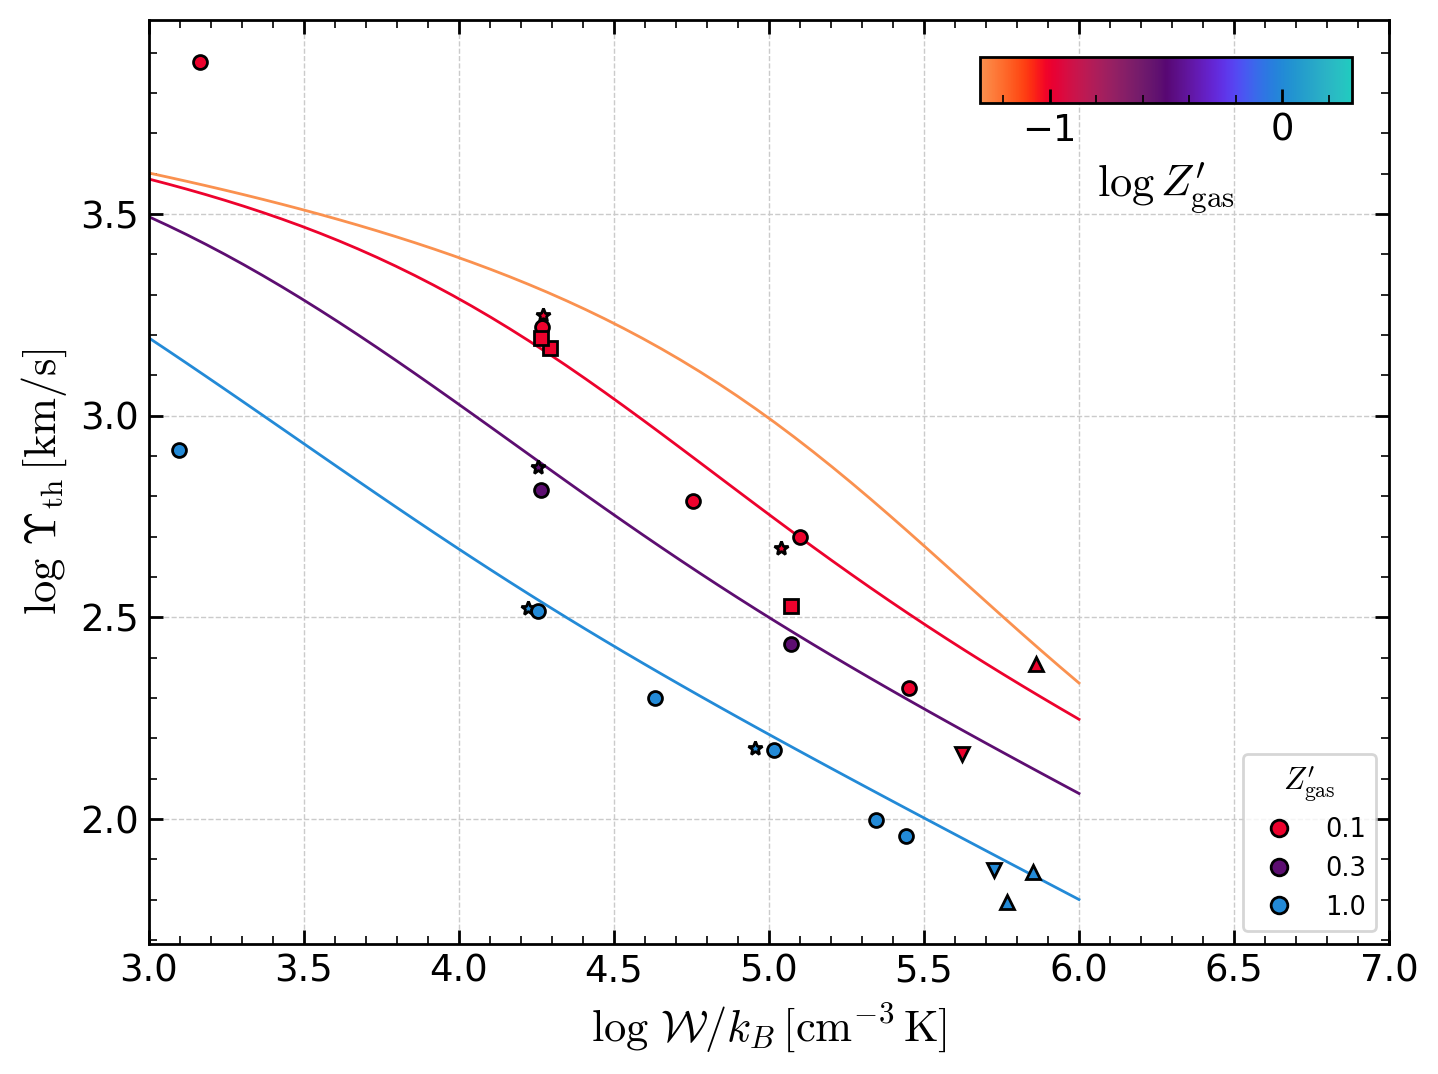

In [195]:
plot_fitting_mean(qdset,model_dset,x1,yf,legend=4,colorbar=1,model=False)
for Zd in [0.025,0.1,0.3,1]:
    plt.plot(np.log10(W_x),np.log10((1.5*np.log10(1e4/W_x+Zd+0.01)+2.5)*(W_x/1.e4*Zd**2+0.01)**(-0.4))+2.2,
             color=cmap(norm(np.log10(Zd))),lw=1)
    # plt.plot(np.log10(W_x),np.log10((W_x/1.e4*Zd**2)**(-0.25)*(W_x/1.e4)**(-0.2))+2.7,
         # color=cmap(norm(np.log10(Zd))),lw=1)
plt.xlim(3,7)